In [30]:
%reload_ext XXX.mumble

%reload_ext XXX.mumble

In [35]:

    from poser import *
    from notebook.utils import url_path_join as ujoin
    from importlib import reload
    import requests
    import requests_cache    

In [36]:
    
    get_ipython().ast_node_interactivity='last_expr_or_assign'
    requests_cache.install_cache("election")

In [37]:
    ---
    urls:
        prefix: http://results.enr.clarityelections.com/GA/
        reports: http://results.enr.clarityelections.com/GA/63991/184321/en/reports.html
        ga: http://results.enr.clarityelections.com/GA/
        elections: http://results.enr.clarityelections.com/GA/elections.json
        county: http://results.enr.clarityelections.com/GA/63991/184321/en/select-county.html
        franklin: http://results.enr.clarityelections.com/GA/Franklin/64051/
        franklin_redir: http://results.enr.clarityelections.com/GA/Franklin/64051/183122/en/summary.html
        json: http://results.enr.clarityelections.com/GA/63991/184321/json/status.json
        select: http://results.enr.clarityelections.com/GA/63991/184321/en/select-county.html
        wiki: https://en.wikipedia.org/wiki/List_of_counties_in_Georgia_(U.S._state)

    ---
    urls:
        prefix: http://results.enr.clarityelections.com/GA/
        reports: http://results.enr.clarityelections.com/GA/63991/184321/en/reports.html
        ga: http://results.enr.clarityelections.com/GA/
        elections: http://results.enr.clarityelections.com/GA/elections.json
        county: http://results.enr.clarityelections.com/GA/63991/184321/en/select-county.html
        franklin: http://results.enr.clarityelections.com/GA/Franklin/64051/
        franklin_redir: http://results.enr.clarityelections.com/GA/Franklin/64051/183122/en/summary.html
        json: http://results.enr.clarityelections.com/GA/63991/184321/json/status.json
        select: http://results.enr.clarityelections.com/GA/63991/184321/en/select-county.html
        wiki: https://en.wikipedia.org/wiki/List_of_counties_in_Georgia_(U.S._state)

In [5]:

    read_html, get =(a/cache)((a.pandas.read_html(), a.requests.get()))
    get = requests.get

<function requests.api.get>

In [6]:
    num_counties = (a[read_html].drop(2).first().len()[x-1])(urls['wiki'])

    num_counties = (a[read_html].drop(2).first().len()[x-1])(urls['wiki'])

159

In [7]:
# A List of All of the Counties

    soup = a[get][x.text].bs4.BeautifulSoup(features='lxml')(urls['county'])
    county = (a.map(x.attrs['value']).list())(soup.select('table tr li a'));
    assert len(county) is num_counties, """The number of rows is not the number of counties."""

# A List of All of the Counties

    soup = a[get][x.text].bs4.BeautifulSoup(features='lxml')(urls['county'])
    county = (a.map(x.attrs['value']).list())(soup.select('table tr li a'));
    assert len(county) is num_counties, """The number of rows is not the number of counties."""

In [8]:
# The County Event ID

    event_ids = a.map(a.str.split('/').filter(bool).take(2)).dict()(county);
    a.dict.items().take(3).dict()(event_ids)

# The County Event ID

    event_ids = a.map(a.str.split('/').filter(bool).take(2)).dict()(county);
    a.dict.items().take(3).dict()(event_ids)

{'Appling': '63993', 'Atkinson': '63994', 'Bacon': '63995'}

In [9]:
    def construct_context_version(name='Appling', sleep=1):
        latest_version = a[[a.identity(), event_ids.__getitem__]][
            [urls["prefix"]], a.identity(), ['current_ver.txt']
        ].concat()['/'.join][get][x.text]

        constructed = ujoin(urls["prefix"], name, event_ids[name], latest_version(name))
        constructed = ujoin(constructed , 'json/{}.json').format
        return a.map(constructed).map((
            a.str.rsplit('/', 1).last().str.replace('.json', ''), 
            a[get].methodcaller('json'))).dict()(('sum', 'details', 'status'))

    def construct_context_version(name='Appling', sleep=1):
        latest_version = a[[a.identity(), event_ids.__getitem__]][
            [urls["prefix"]], a.identity(), ['current_ver.txt']
        ].concat()['/'.join][get][x.text]

        constructed = ujoin(urls["prefix"], name, event_ids[name], latest_version(name))
        constructed = ujoin(constructed , 'json/{}.json').format
        return a.map(constructed).map((
            a.str.rsplit('/', 1).last().str.replace('.json', ''), 
            a[get].methodcaller('json'))).dict()(('sum', 'details', 'status'))

In [10]:
    ---
    labels:
        CH: Candidate
        C: Office
        V: Votes
        TV: Total Voters
        BC: Ballot Cast

    ---
    labels:
        CH: Candidate
        C: Office
        V: Votes
        TV: Total Voters
        BC: Ballot Cast

In [11]:
    def tidy_precinct(s):
        return a.zip().dict().valmap(
            a.zip(s.Candidate).dict()
        ).pandas.DataFrame()(s.P, s.V)

    def tidy_precinct(s):
        return a.zip().dict().valmap(
            a.zip(s.Candidate).dict()
        ).pandas.DataFrame()(s.P, s.V)

In [12]:
    dfs = {}
    for i, county in enumerate(event_ids):
        print(i, county)
        objects = construct_context_version(county)
        
        df = (a.pandas.DataFrame())(objects['sum']['Contests'])
        
        # assert df.V.apply(sum).lt(df.TV).all()
        df = df[list(labels)].rename(columns=labels)
        df = (a.pandas.DataFrame()[df.join])(objects['details']['Contests'])

        dfs[county] = a.pandas.concat()({index: tidy_precinct(row)
            for index, row in df.set_index('Office').iterrows() 
            if (a**list)(row.P) or not a.pandas.np.isnan()(row.P)})

    dfs = {}
    for i, county in enumerate(event_ids):
        print(i, county)
        objects = construct_context_version(county)
        
        df = (a.pandas.DataFrame())(objects['sum']['Contests'])
        
        # assert df.V.apply(sum).lt(df.TV).all()
        df = df[list(labels)].rename(columns=labels)
        df = (a.pandas.DataFrame()[df.join])(objects['details']['Contests'])

        dfs[county] = a.pandas.concat()({index: tidy_precinct(row)
            for index, row in df.set_index('Office').iterrows() 
            if (a**list)(row.P) or not a.pandas.np.isnan()(row.P)})

0 Appling
1 Atkinson
2 Bacon
3 Baker
4 Baldwin
5 Banks
6 Barrow
7 Bartow
8 Ben_Hill
9 Berrien
10 Bibb
11 Bleckley
12 Brantley
13 Brooks
14 Bryan
15 Bulloch
16 Burke
17 Butts
18 Calhoun
19 Camden
20 Candler
21 Carroll
22 Catoosa
23 Charlton
24 Chatham
25 Chattahoochee
26 Chattooga
27 Cherokee
28 Clarke
29 Clay
30 Clayton
31 Clinch
32 Cobb
33 Coffee
34 Colquitt
35 Columbia
36 Cook
37 Coweta
38 Crawford
39 Crisp
40 Dade
41 Dawson
42 Decatur
43 DeKalb
44 Dodge
45 Dooly
46 Dougherty
47 Douglas
48 Early
49 Echols
50 Effingham
51 Elbert
52 Emanuel
53 Evans
54 Fannin
55 Fayette
56 Floyd
57 Forsyth
58 Franklin
59 Fulton
60 Gilmer
61 Glascock
62 Glynn
63 Gordon
64 Grady
65 Greene
66 Gwinnett
67 Habersham
68 Hall
69 Hancock
70 Haralson
71 Harris
72 Hart
73 Heard
74 Henry
75 Houston
76 Irwin
77 Jackson
78 Jasper
79 Jeff_Davis
80 Jefferson
81 Jenkins
82 Johnson
83 Jones
84 Lamar
85 Lanier
86 Laurens
87 Lee
88 Liberty
89 Lincoln
90 Long
91 Lowndes
92 Lumpkin
93 Macon
94 Madison
95 Marion
96 McDuffie

In [13]:
    tidy = a.pandas.concat()(dfs)

    tidy = tidy.swaplevel(0,1).stack().pipe(
        lambda df: a.pandas.Series()(df.values, df.index.rename(('contest', 'county', 'candidate', 'precinct')))
    ).rename('votes')

    tidy = a.pandas.concat()(dfs)

    tidy = tidy.swaplevel(0,1).stack().pipe(
        lambda df: a.pandas.Series()(df.values, df.index.rename(('contest', 'county', 'candidate', 'precinct')))
    ).rename('votes')

contest                         county   candidate           precinct    
CC, D2                          Appling  T. WILKERSON (I) D  2               945.0
CC, D4                          Appling  R. RENTZ (I) R      4A              248.0
                                                             4B              274.0
                                                             4C              255.0
                                                             4D              625.0
CC, D5                          Appling  C. LEGGETT (I) R    5A              513.0
                                                             5B              327.0
                                                             5C              225.0
CLERK SUPERIOR COURT            Appling  M. THOMAS (I) R     1B              692.0
                                                             1C              481.0
                                                             2               801.0
             

In [14]:
    tidy.to_csv('all_contests_precinct.csv')
    tidy.loc['President of the United States'].to_csv('president_precinct.csv')

    tidy.to_csv('all_contests_precinct.csv')
    tidy.loc['President of the United States'].to_csv('president_precinct.csv')

> I want election **results** by **precinct** in **Georgia** for the **2016 presidential election**. The problem is that results are broken down by county in details.xls on the Georgia Secretary of State's website. However, precinct-level details are available for each of Georgia's 159 counties 

![](./state_list.png)

in individual reports (also titled details.xls). 

![](./county_example.png)

In [15]:
    the.pandas.DataFrame()(tidy)

    the.pandas.DataFrame()(tidy)

votes
contest                        county  candidate          precinct           
CC, D2                         Appling T. WILKERSON (I) D 2             945.0
CC, D4                         Appling R. RENTZ (I) R     4A            248.0
                                                          4B            274.0
                                                          4C            255.0
                                                          4D            625.0
CC, D5                         Appling C. LEGGETT (I) R   5A            513.0
                                                          5B            327.0
                                                          5C            225.0
CLERK SUPERIOR COURT           Appling M. THOMAS (I) R    1B            692.0
                                                          1C            481.0
                                                          2             801.0
                                                          3A            203.0
                                                          3A1           303.0
                                                          3B            130.0
                                                          3C            738.0
                                                          4A            252.0
                                                          4B            284.0
                                                          4C            263.0
                                                          4D            645.0
                                                          5A            537.0
                                                          5B            340.0
                                                          5C            238.0
CORONER                        Appling J. MURPHY (I) R    1B            669.0
                                                          1C            469.0
                                                          2             757.0
                                                          3A            196.0
                                                          3A1           310.0
                                                          3B            120.0
                                                          3C            725.0
                                                          4A            253.0
...                                                                       ...
United States Senator, Isakson Worth   JIM BARKSDALE      Bridgeboro    123.0
                                                          County Line    70.0
                                                          Doles          26.0
                                                          Isabella       90.0
                                                          Minton         27.0
                                                          Oakfield       46.0
                                                          Piney Woods    60.0
                                                          Poulan         90.0
                                                          Red Rock      126.0
                                                          Scooterville   22.0
                                                          Shingler       47.0
                                                          Sumner         92.0
                                                          Sylver East   146.0
                                                          Sylvester     758.0
                                                          Warwick       116.0
                                       JOHNNY ISAKSON (I) Bridgeboro    597.0
                                                          County Line   318.0
                                                          Doles         244.0
                                                          Isabella      771.0
                

In [16]:

    import Maps
    reload(Maps)

%reload_ext XXX.mumble

    %matplotlib inline

    ---
    urls:
        congress12: http://www.legis.ga.gov/Joint/reapportionment/Documents/SEPT%202012/CONGRESS12-SHAPE.zip
        vtd2016: http://www.legis.ga.gov/Joint/reapportionment/Documents/VTD2016-SHAPE.zip
        vtd2014: http://www.legis.ga.gov/Joint/reapportionment/Documents/VTD2014-SHAPE.zip

    dfs = {}

    for k, url in urls.items():
        with zipfile.ZipFile(BytesIO(get(urls[k]).content)) as zf:
            for fname in zf.namelist():
                if fname.lower().endswith("shp"):
                    with tempfile.TemporaryDirectory() as td:
                        zf.extractall(td)
                        dfs[k] = geopandas.read_file(str(Path(td) / fname))
                        print(k, dfs[k].columns)

    dfs['vtd2016']

congress12 Index(['ID', 'AREA', 'DISTRICT', 'MEMBERS', 'LOCKED', 'NAME', 'POPULATION',
       'F18_POP', 'BLACK', 'F18_BLK', 'BLACK_COMB', 'BLACK_COM1', 'TOTAL_BLAC',
       'TOTAL_BLA1', 'HISPANIC_O', 'H18_POP', 'REG10', 'BLREG10', 'HREG10',
       'DEVIATION', 'F_DEVIATIO', 'F_18_POP', 'F_BLACK', 'F_18_BLK',
       'F_BLACK_CO', 'F_TOTAL_BL', 'F_TOTAL_B1', 'F_HISPANIC', 'F_H18_POP',
       'F_BLREG10', 'F_HREG10', 'F_BLACK_C1', 'IDEAL_VALU', 'geometry'],
      dtype='object')
vtd2016 Index(['geometry'], dtype='object')
vtd2014 Index(['ID', 'AREA', 'DATA', 'DISTRICT', 'CTYSOSID', 'PRECINCT_I',
       'PRECINCT_N', 'COUNTY', 'COUNTY_NAM', 'FIPS2', 'geometry'],
      dtype='object')
congress12 Index(['ID', 'AREA', 'DISTRICT', 'MEMBERS', 'LOCKED', 'NAME', 'POPULATION',
       'F18_POP', 'BLACK', 'F18_BLK', 'BLACK_COMB', 'BLACK_COM1', 'TOTAL_BLAC',
       'TOTAL_BLA1', 'HISPANIC_O', 'H18_POP', 'REG10', 'BLREG10', 'HREG10',
       'DEVIATION', 'F_DEVIATIO', 'F_18_POP', 'F_BLACK', 'F_18_BLK

<module 'Maps' from '/home/weg/Documents/mark/election/Maps.ipynb'>

In [17]:

    vote_county_precincts = (
        tidy['President of the United States']
        .reset_index()[["county", "precinct", "candidate", "votes"]]
        .rename({"county": "COUNTY_NAM", "precinct": "PRECINCT_N"}, axis="columns")
        .sort_values(['COUNTY_NAM', 'PRECINCT_N'])
        .drop_duplicates()
        .dropna()
    )
    vote_county_precincts['COUNTY_NAM'] = vote_county_precincts['COUNTY_NAM'].str.upper()
    vote_county_precincts['PRECINCT_N'] = vote_county_precincts['PRECINCT_N'].str.upper()
    vote_county_precincts = vote_county_precincts.set_index(['COUNTY_NAM', 'PRECINCT_N'])

candidate  votes
COUNTY_NAM PRECINCT_N                                
APPLING    1B            DONALD J. TRUMP (REP)  685.0
           1B               GARY JOHNSON (LIB)    9.0
           1B            HILLARY CLINTON (DEM)   92.0
           1C            DONALD J. TRUMP (REP)  496.0
           1C               GARY JOHNSON (LIB)    5.0
           1C            HILLARY CLINTON (DEM)   42.0
           2             DONALD J. TRUMP (REP)  427.0
           2                GARY JOHNSON (LIB)   10.0
           2             HILLARY CLINTON (DEM)  742.0
           3A            DONALD J. TRUMP (REP)  209.0
           3A               GARY JOHNSON (LIB)    4.0
           3A            HILLARY CLINTON (DEM)    4.0
           3A1           DONALD J. TRUMP (REP)  319.0
           3A1              GARY JOHNSON (LIB)    1.0
           3A1           HILLARY CLINTON (DEM)   17.0
           3B            DONALD J. TRUMP (REP)  101.0
           3B               GARY JOHNSON (LIB)    1.0
           3B            HILLARY CLINTON (DEM)   98.0
           3C            DONALD J. TRUMP (REP)  670.0
           3C               GARY JOHNSON (LIB)   14.0
           3C            HILLARY CLINTON (DEM)  154.0
           4A            DONALD J. TRUMP (REP)  261.0
           4A               GARY JOHNSON (LIB)    1.0
           4A            HILLARY CLINTON (DEM)   14.0
           4B            DONALD J. TRUMP (REP)  305.0
           4B               GARY JOHNSON (LIB)    0.0
           4B            HILLARY CLINTON (DEM)    7.0
           4C            DONALD J. TRUMP (REP)  284.0
           4C               GARY JOHNSON (LIB)    2.0
           4C            HILLARY CLINTON (DEM)   10.0
...                                        ...    ...
WORTH      OAKFIELD            DONALD J. TRUMP   91.0
           OAKFIELD               GARY JOHNSON    1.0
           OAKFIELD            HILLARY CLINTON   45.0
           PINEY WOODS         DONALD J. TRUMP  113.0
           PINEY WOODS            GARY JOHNSON    3.0
           PINEY WOODS         HILLARY CLINTON   72.0
           POULAN              DONALD J. TRUMP  436.0
           POULAN                 GARY JOHNSON    2.0
           POULAN              HILLARY CLINTON   93.0
           RED ROCK            DONALD J. TRUMP  523.0
           RED ROCK               GARY JOHNSON    8.0
           RED ROCK            HILLARY CLINTON  135.0
           SCOOTERVILLE        DONALD J. TRUMP  339.0
           SCOOTERVILLE           GARY JOHNSON    0.0
           SCOOTERVILLE        HILLARY CLINTON   22.0
           SHINGLER            DONALD J. TRUMP  337.0
           SHINGLER               GARY JOHNSON    4.0
           SHINGLER            HILLARY CLINTON   47.0
           SUMNER              DONALD J. TRUMP  418.0
           SUMNER                 GARY JOHNSON    3.0
           SUMNER              HILLARY CLINTON   91.0
           SYLVER EAST         DONALD J. TRUMP  664.0
           SYLVER EAST            GARY JOHNSON   25.0
           SYLVER EAST         HILLARY CLINTON  162.0
           SYLVESTER           DONALD J. TRUMP  562.0
           SYLVESTER              GARY JOHNSON   16.0
           SYLVESTER           HILLARY CLINTON  905.0
           WARWICK             DONALD J. TRUMP  300.0
           WARWICK                GARY JOHNSON    6.0
           WARWICK             HILLARY CLINTON  127.0

[8079 rows x 2 columns]

In [20]:

    map_county_precincts = (Maps.dfs['vtd2014'][['PRECINCT_N', 'COUNTY_NAM', 'geometry']]
                            .sort_values(['COUNTY_NAM', 'PRECINCT_N'])
                            .dropna())
    map_county_precincts['PRECINCT_N'] = map_county_precincts['PRECINCT_N'].apply(str)
    map_county_precincts = map_county_precincts.set_index(['COUNTY_NAM', 'PRECINCT_N'])

geometry
COUNTY_NAM PRECINCT_N                                                             
APPLING    1B                    POLYGON ((-82.289551 31.939846, -82.288736 31....
           1C                    POLYGON ((-82.282151 31.850228, -82.282129 31....
           2                     POLYGON ((-82.28709499999999 31.840288, -82.28...
           3A                    POLYGON ((-82.190602 31.787087, -82.1907109999...
           3A1                   POLYGON ((-82.283232 31.905263, -82.283208 31....
           3B                    POLYGON ((-82.234784 31.761919, -82.234891 31....
           3C                    POLYGON ((-82.297628 31.766487, -82.295603 31....
           4A                    POLYGON ((-82.152796 31.632626, -82.151864 31....
           4B                    POLYGON ((-82.188625 31.63607, -82.187073 31.6...
           4C                    POLYGON ((-82.265563 31.678946, -82.264927 31....
           4D                    POLYGON ((-82.271366 31.689666, -82.271247 31....
           5A                    POLYGON ((-82.364272 31.78376, -82.363378 31.7...
           5B                    POLYGON ((-82.45232799999999 31.813747, -82.45...
           5C                    POLYGON ((-82.427035 31.662189, -82.428375 31....
ATKINSON   AXSON                 POLYGON ((-82.76477800000001 31.351417, -82.76...
           PEARSON CITY          POLYGON ((-82.848409 31.311505, -82.847881 31....
           PEARSON COUNTY        (POLYGON ((-82.97587300000001 31.256429, -82.9...
           WILLACOOCHEE          POLYGON ((-82.971103 31.258319, -82.971739 31....
BACON      DOUGLAS               POLYGON ((-82.49471800000001 31.46869, -82.499...
           NEW LACY              POLYGON ((-82.344897 31.434402, -82.344891 31....
           TAYLOR                POLYGON ((-82.50398 31.58341, -82.504878000000...
           WARE                  POLYGON ((-82.401748 31.420199, -82.401732 31....
           WARNOCK               POLYGON ((-82.37817200000001 31.632332, -82.37...
BAKER      ANNA                  POLYGON ((-84.598243 31.337624, -84.5973 31.33...
           ELMODEL               POLYGON ((-84.484948 31.319124, -84.4858 31.31...
           HOGGARDS MILL         POLYGON ((-84.504394 31.273776, -84.502229 31....
           MILFORD               POLYGON ((-84.582016 31.339937, -84.582487 31....
           NEWTON                POLYGON ((-84.419979 31.297686, -84.4199590000...
BALDWIN    BODDIE                POLYGON ((-83.23137199999999 33.101127, -83.23...
           CITY HALL ANNEX       POLYGON ((-83.223581 33.038251, -83.223675 33....
...                                                                            ...
WILKES     EDWARD B POPE CENTER  POLYGON ((-82.90509299999999 33.698313, -82.90...
           METASVILLE FIRE STA   POLYGON ((-82.594553 33.828429, -82.5945130000...
           RAYLE CITY HALL       POLYGON ((-82.980735 33.773748, -82.9807409999...
           SENIOR CITIZEN CENTE  POLYGON ((-82.76412000000001 33.623903, -82.76...
           TIGNALL SCH LUNCH RM  POLYGON ((-82.704842 33.981936, -82.7028580000...
           YOUNG FARMER'S BLDG   POLYGON ((-82.64852 33.608382, -82.64854800000...
WILKINSON  BLOODWORTH            POLYGON ((-83.172032 32.97949, -83.174066 32.9...
           GRIFFIN               POLYGON ((-83.061503 32.66369, -83.06177599999...
           HIGH HILL             POLYGON ((-83.28381299999999 32.681282, -83.28...
           IRWINTON              POLYGON ((-83.35849399999999 32.81283, -83.358...
           IVEY                  POLYGON ((-83.266755 32.9571, -83.266763 32.95...
           LORD                  POLYGON ((-82.957066 32.708318, -82.957104 32....
           MIDWAY                POLYGON ((-83.159147 32.851244, -83.159074 32....
           RAMAH                 POLYGON ((-83.40698999999999 32.89822, -83.406...
           TURKEY CREEK          POLYGON ((-83.218744 32.588082, -83.218771 32....
WORTH      BRIDGEBORO            POLYGON ((-83.944154 31.334291, -83.9457720000...
       

In [21]:

    joined = map_county_precincts.join(vote_county_precincts, how='outer').dropna()

geometry  \
COUNTY_NAM PRECINCT_N                                                        
APPLING    1B            POLYGON ((-82.289551 31.939846, -82.288736 31....   
           1B            POLYGON ((-82.289551 31.939846, -82.288736 31....   
           1B            POLYGON ((-82.289551 31.939846, -82.288736 31....   
           1C            POLYGON ((-82.282151 31.850228, -82.282129 31....   
           1C            POLYGON ((-82.282151 31.850228, -82.282129 31....   
           1C            POLYGON ((-82.282151 31.850228, -82.282129 31....   
           2             POLYGON ((-82.28709499999999 31.840288, -82.28...   
           2             POLYGON ((-82.28709499999999 31.840288, -82.28...   
           2             POLYGON ((-82.28709499999999 31.840288, -82.28...   
           3A            POLYGON ((-82.190602 31.787087, -82.1907109999...   
           3A            POLYGON ((-82.190602 31.787087, -82.1907109999...   
           3A            POLYGON ((-82.190602 31.787087, -82.1907109999...   
           3A1           POLYGON ((-82.283232 31.905263, -82.283208 31....   
           3A1           POLYGON ((-82.283232 31.905263, -82.283208 31....   
           3A1           POLYGON ((-82.283232 31.905263, -82.283208 31....   
           3B            POLYGON ((-82.234784 31.761919, -82.234891 31....   
           3B            POLYGON ((-82.234784 31.761919, -82.234891 31....   
           3B            POLYGON ((-82.234784 31.761919, -82.234891 31....   
           3C            POLYGON ((-82.297628 31.766487, -82.295603 31....   
           3C            POLYGON ((-82.297628 31.766487, -82.295603 31....   
           3C            POLYGON ((-82.297628 31.766487, -82.295603 31....   
           4A            POLYGON ((-82.152796 31.632626, -82.151864 31....   
           4A            POLYGON ((-82.152796 31.632626, -82.151864 31....   
           4A            POLYGON ((-82.152796 31.632626, -82.151864 31....   
           4B            POLYGON ((-82.188625 31.63607, -82.187073 31.6...   
           4B            POLYGON ((-82.188625 31.63607, -82.187073 31.6...   
           4B            POLYGON ((-82.188625 31.63607, -82.187073 31.6...   
           4C            POLYGON ((-82.265563 31.678946, -82.264927 31....   
           4C            POLYGON ((-82.265563 31.678946, -82.264927 31....   
           4C            POLYGON ((-82.265563 31.678946, -82.264927 31....   
...                                                                    ...   
WORTH      MINTON        POLYGON ((-83.819287 31.332732, -83.8193019999...   
           MINTON        POLYGON ((-83.819287 31.332732, -83.8193019999...   
           MINTON        POLYGON ((-83.819287 31.332732, -83.8193019999...   
           OAKFIELD      POLYGON ((-83.98661800000001 31.769644, -83.98...   
           OAKFIELD      POLYGON ((-83.98661800000001 31.769644, -83.98...   
           OAKFIELD      POLYGON ((-83.98661800000001 31.769644, -83.98...   
           PINEY WOODS   POLYGON ((-83.9903 31.55165, -83.982451 31.551...   
           PINEY WOODS   POLYGON ((-83.9903 31.55165, -83.982451 31.551...   
           PINEY WOODS   POLYGON ((-83.9903 31.55165, -83.982451 31.551...   
           POULAN        POLYGON ((-83.81124199999999 31.522121, -83.81...   
           POULAN        POLYGON ((-83.81124199999999 31.522121, -83.81...   
           POULAN        POLYGON ((-83.81124199999999 31.522121, -83.81...   
           RED ROCK      POLYGON ((-83.996448 31.585426, -83.9964400000...   
           RED ROCK      POLYGON ((-83.996448 31.585426, -83.9964400000...   
           RED ROCK      POLYGON ((-83.996448 31.585426, -83.9964400000...   
           SCOOTERVILLE  POLYGON ((-83.668819 31.33091, -83.67325599999...   
           SCOOTERVILLE  POLYGON ((-83.668819 31.33091, -83.67325599999...   
           SCOOTERVILLE  POLYGON ((-83.668819 31.33091, -83.67325599999...   
           SHINGLER      POLYGON ((-83.649384 31.567977, -83.6494019999...   
          

In [22]:

    trump = joined['candidate'].str.contains('TRUMP')
    clinton = joined['candidate'].str.contains('CLINTON');

In [23]:

    red = joined[(joined[trump]['votes'] > joined[clinton]['votes']) & trump]
    red['color'] = 1
    red.size

/home/weg/miniconda3/envs/election/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


5064

In [24]:

    blue = joined[(joined[trump]['votes'] < joined[clinton]['votes']) & clinton]
    blue['color'] = 0
    blue.size

/home/weg/miniconda3/envs/election/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


3476

In [29]:

    red_blue = the.pandas.concat()([blue, red]);

    red_blue.plot(column='color', cmap='bwr');

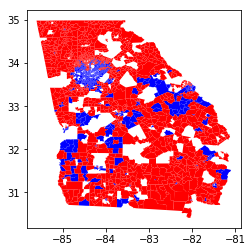

In [27]:
    red_blue.plot(column='color', cmap='bwr');